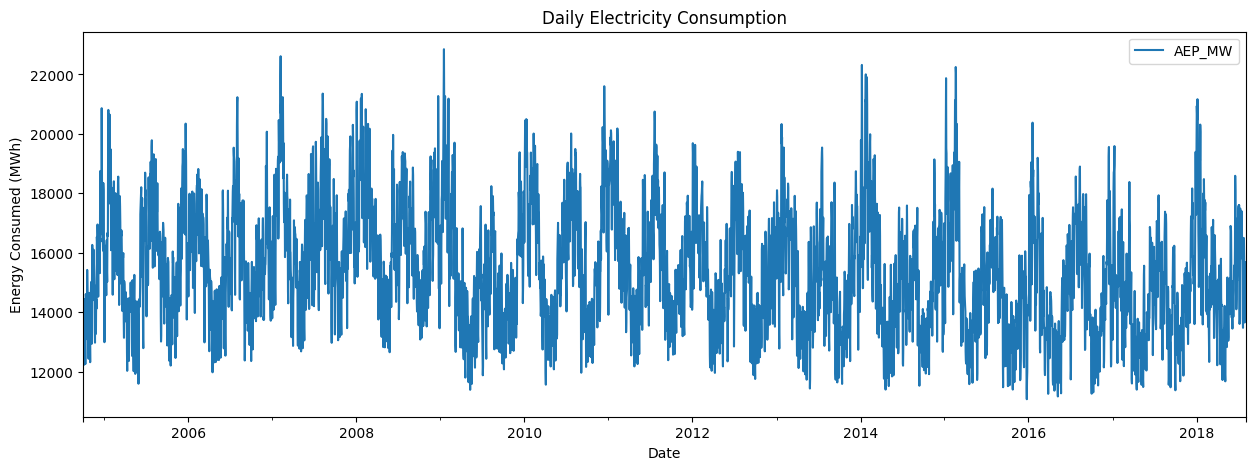

In [24]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 1. Dataset Preparation: 1. Select a time series dataset suitable for forecasting tasks (e.g., stock prices,weather data, energy consumption).

import pandas as pd
#!pip install matplotlib
import matplotlib.pyplot as plt

# Replace the path with your actual file path where the CSV file is stored
file_path = 'C:/Users/M1097753/Downloads/archive/AEP_hourly.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Convert the Datetime column to a datetime type and set it as the index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# For simplicity, let's resample the data to daily frequency by taking the average daily consumption
df_daily = df.resample('D').mean()

# Quick visualization to understand the data
df_daily.plot(figsize=(15, 5))
plt.title('Daily Electricity Consumption')
plt.ylabel('Energy Consumed (MWh)')
plt.xlabel('Date')
plt.show()


In [25]:
#Student Name: Yamini Saraswathi Borra
#Student ID: 700748022
# 1. DataSet Preparation: 2.Preprocess the dataset, including normalization and splitting into training and test sets.
import numpy as np

# Check for missing values
if df_daily.isnull().sum().sum() > 0:
    # Fill missing values with the previous day's data
    df_daily.fillna(method='ffill', inplace=True)


In [27]:
# Normalize the Dataset
#!pip install scikit-learn

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_daily_scaled = scaler.fit_transform(df_daily.values.reshape(-1, 1))  # Reshape is required to make it 2D array
df_daily_scaled = np.squeeze(df_daily_scaled)  # Convert back to 1D array for simplicity


In [28]:
#Split the Data into Training and Test Sets
# Define the train and test set sizes
train_size = int(len(df_daily_scaled) - 365)
test_size = len(df_daily_scaled) - train_size

# Split the data into train and test sets
train, test = df_daily_scaled[0:train_size], df_daily_scaled[train_size:len(df_daily_scaled)]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')


Train set size: 4690
Test set size: 365


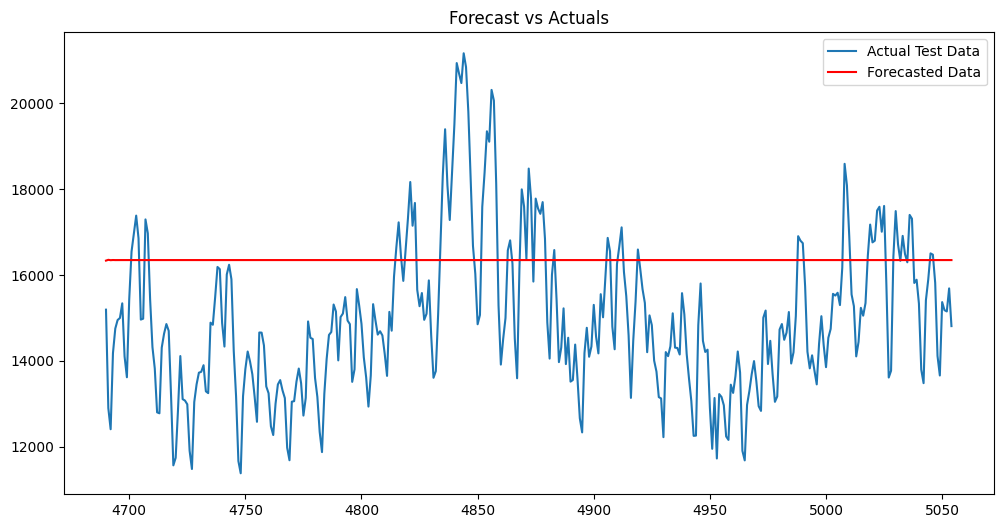

In [29]:
#Example of a Time Series Forecasting Model Setup
#!pip install statsmodels

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARIMA model on the training data
model = ARIMA(train, order=(1, 1, 1))  # These parameters (p,d,q) usually require tuning
fitted_model = model.fit()

# Forecasting the next 'test_size' points to compare against the actual test set
forecast = fitted_model.forecast(steps=test_size)

# Inverse the scaling to compare it against the original data
forecast = scaler.inverse_transform(forecast.reshape(-1, 1))
test_original = scaler.inverse_transform(test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train), len(train) + len(test)), test_original, label='Actual Test Data')
plt.plot(np.arange(len(train), len(train) + len(test)), forecast, color='red', label='Forecasted Data')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()


In [30]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
#2. Model Architecture - 1. Design an LSTM-based architecture capable of capturing long-term dependencies in the input sequences.
#Step1: Prepare the data for LSTM
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Function to create sequences of data
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Number of past days we want to use to predict the future
look_back = 14  # Use the last 14 days to predict the next day

# Prepare data
train_X, train_Y = create_dataset(train.reshape(-1,1), look_back)
test_X, test_Y = create_dataset(test.reshape(-1,1), look_back)

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))


In [31]:
#Step 2: Design the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\M1097753\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
#Step 3: Train the Model
# Fit the model
history = model.fit(train_X, train_Y, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0444 - val_loss: 0.0139
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0150 - val_loss: 0.0139
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0129 - val_loss: 0.0119
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0121 - val_loss: 0.0094
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 9/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 10/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 11/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 12/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


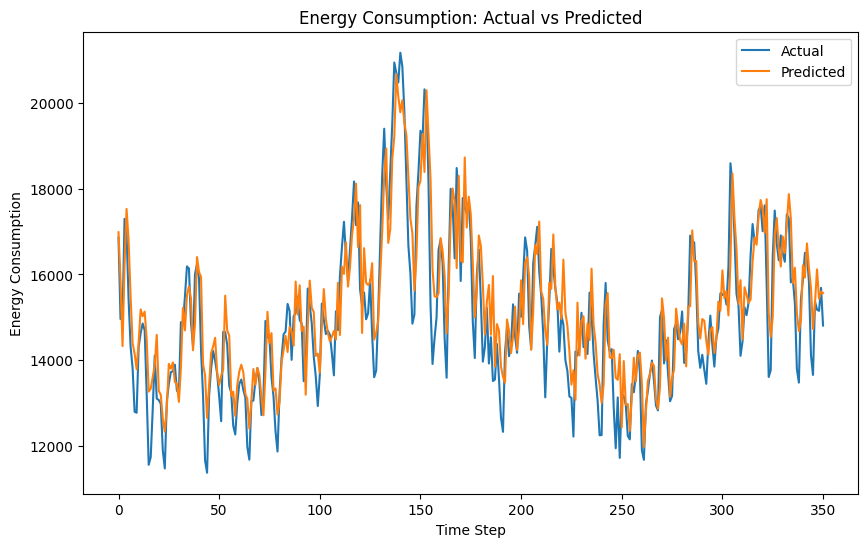

In [33]:
#Step4: Evaluate the Model
# Predicting and reversing normalization
test_predict = model.predict(test_X)
test_predict = scaler.inverse_transform(test_predict)
test_Y_actual = scaler.inverse_transform(test_Y.reshape(-1, 1))

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test_Y_actual, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


In [34]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 2. Model Architecture - 2. Experiment with stacking multiple LSTM layers and adjusting the number of units in each layer.
import pandas as pd

# Load training data from a CSV file
train_data = pd.read_csv('C:/Users/M1097753/Downloads/archive/AEP_hourly.csv')

# Display the first few rows of the training data to inspect its structure
print(train_data.head())

# Extract the relevant column(s) from the training data
# Replace 'column_name' with the actual column name(s) containing your training data
train = train_data['AEP_MW']  # For a single column
# OR
# train = train_data[['column1', 'column2', ...]]  # For multiple columns

# Now you can use the 'train' variable in your code
model = ARIMA(train, order=(1, 1, 1))  # Example usage of 'train' in ARIMA model fitting


              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0


In [42]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Sample data
X = np.random.rand(100, 10, 1)  # Example features (100 samples, 10 timesteps, 1 feature)
y = np.random.randint(0, 2, size=(100,))  # Example labels

# Define the model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(10, 1)),  # First LSTM layer with 64 units
    LSTM(32),  # Second LSTM layer with 32 units
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X, y, epochs=10, validation_split=0.2)




Epoch 1/10


C:\Users\M1097753\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.4422 - loss: 0.6948 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5695 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4922 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5227 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6164 - loss: 0.6920 - val_accuracy: 0.5500 - val_loss: 0.6926
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5312 - loss: 0.6917 - val_accuracy: 0.5500 - val_loss: 0.6910
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4805 - loss: 0.6910 - val_accuracy: 0.5500 - val_loss: 0.6904
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4883 - loss: 0.6914 - val_accuracy: 0.5500 - val_loss: 0.6897
Epoch 9/10

In [21]:
# Step 2: Design a Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Define input shape
input_shape = (look_back, 1)  # Assuming 'look_back' is defined

# Build the LSTM model with Input layer
model = Sequential([
    Input(shape=input_shape),
    LSTM(100, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')



In [36]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 2. Model Architecture - 3. Consider using dropout layers to prevent overfitting and improve generalization.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model with dropout layers
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    LSTM(50, return_sequences=True),
    Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    LSTM(25),
    Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\M1097753\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 3. Model Training -1. Compile the LSTM model with an appropriate loss function (e.g., mean squared error) and optimizer (e.g., Adam).
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=True),
    LSTM(25),
    Dense(1)
])

# Compile the model with mean squared error loss function and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')



In [38]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [40]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 3. Model Training - 2. Train the model on the training set for a fixed number of epochs.
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generate sample training data
X = np.random.rand(100, 10)  # Example features
y = np.random.randint(0, 2, size=(100,))  # Example labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model on the training data for a fixed number of epochs
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.4479 - loss: 0.7033 - val_accuracy: 0.5625 - val_loss: 0.6779
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4688 - loss: 0.6926 - val_accuracy: 0.6875 - val_loss: 0.6725
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6146 - loss: 0.6849 - val_accuracy: 0.6875 - val_loss: 0.6696
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5208 - loss: 0.6862 - val_accuracy: 0.6875 - val_loss: 0.6691
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5625 - loss: 0.6747 - val_accuracy: 0.5625 - val_loss: 0.6689
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5521 - loss: 0.6733 - val_accuracy: 0.5625 - val_loss: 0.6693
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5833 - loss: 0.6615 - val_accuracy: 0.5625 - val_loss: 0.6703
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5417 - loss: 0.6667 - val_accuracy: 0.5625 - val_loss: 0.6712

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6042 - loss: 0.6619 - val_accuracy: 0.5625 - val_loss: 0.6729
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5938 - loss: 0.6677 - val_accuracy: 0.6250 - val_loss: 0.6733
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6042 - loss: 0.6592 - val_accuracy: 0.6250 - val_loss: 0.6739
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6354 - loss: 0.6509 - val_accuracy: 0.6250 - val_loss: 0.6743
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6042 - loss: 0.6495 - val_accuracy: 0.6250 - val_loss: 0.6747
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5833 - loss: 0.6511 - val_accuracy: 0.6250 - val_loss: 0.6751
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6042 - loss: 0.6522 - val_accuracy: 0.6250 - val_loss: 0.6758
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5833 - loss: 0.6518 - val_accuracy: 0.6250 - val_loss: 0.6766


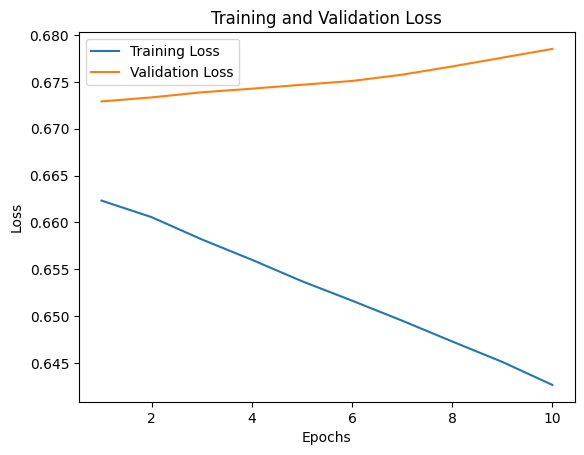

In [41]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 3. Model Training - 3. Monitor training/validation loss to ensure proper convergence.
import matplotlib.pyplot as plt

# Train the model on the training data for a fixed number of epochs
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

# Get training and validation loss from history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

# Plot training and validation loss
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [43]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 4. Model Evaluation: 1. Evaluate the trained model on the test set using relevant evaluation metrics such as mean absolute error (MAE) or root mean squared error (RMSE).
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Sample data
X = np.random.rand(100, 10, 1)  # Example features (100 samples, 10 timesteps, 1 feature)
y = np.random.randint(0, 2, size=(100,))  # Example labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(10, 1)),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Make predictions on the test set
predictions = model.predict(X_test)

# Compute additional evaluation metrics such as MAE or RMSE
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')



Epoch 1/10


C:\Users\M1097753\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.4792 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5104 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5000 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5521 - loss: 0.6884 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5104 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5312 - loss: 0.6897 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5104 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5104 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 9/10

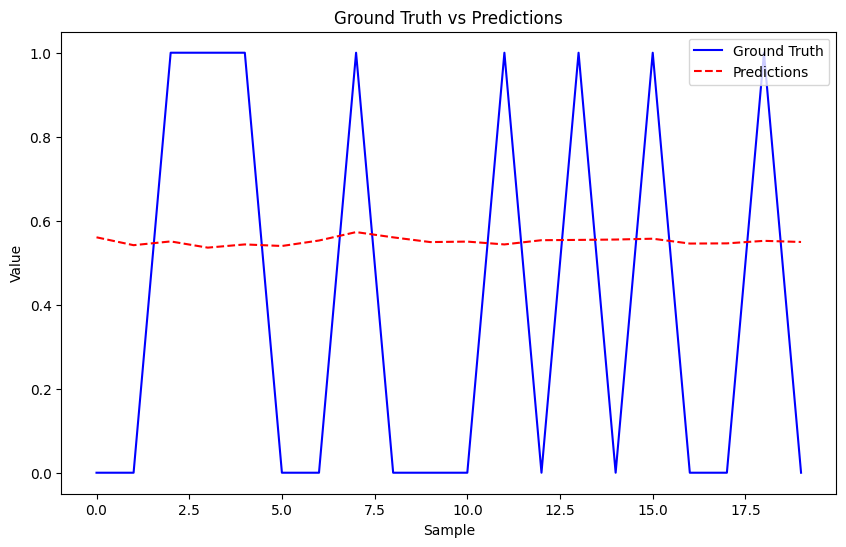

In [44]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 4. Model Evaluation: 2. Visualize the model's predictions against the ground truth to assess its accuracy and performance.

import matplotlib.pyplot as plt

# Plot ground truth and predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Ground Truth', color='blue')
plt.plot(predictions, label='Predictions', color='red', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Ground Truth vs Predictions')
plt.legend()
plt.show()


In [47]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
# 5.Hyperparameter Tuning: 1. Experiment with different hyperparameters such as learning rate, batch size, number of LSTM units, and dropout rate.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Define hyperparameters to experiment with
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
lstm_units = [64, 128, 256]
dropout_rates = [0.1, 0.2, 0.3]

# Iterate over hyperparameters
for lr in learning_rates:
    for bs in batch_sizes:
        for units in lstm_units:
            for dropout_rate in dropout_rates:
                # Define the model architecture
                model = Sequential([
                    LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])),
                    Dropout(dropout_rate),
                    Dense(1)
                ])

                # Compile the model with specific learning rate
                #optimizer = Adam(lr=lr)
                #model.compile(optimizer=optimizer, loss='mse')
                # Compile the model with specific learning rate
                optimizer = Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='mse')

                # Train the model with specific batch size
                model.fit(X_train, y_train, epochs=10, batch_size=bs, validation_split=0.2)

                # Evaluate the model and print results
                loss = model.evaluate(X_test, y_test)
                print(f'Learning Rate: {lr}, Batch Size: {bs}, LSTM Units: {units}, Dropout Rate: {dropout_rate}, Test Loss: {loss}')


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - loss: 0.5349 - val_loss: 0.4306
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4502 - val_loss: 0.3670
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4042 - val_loss: 0.3130
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3469 - val_loss: 0.2701
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2597 - val_loss: 0.2427
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2682 - val_loss: 0.2301
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2515 - val_loss: 0.2359
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2555 - val_loss: 0.2523
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2627 - val_loss: 0.2609
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2691 - val_loss: 0.2570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2990
Learning Rate: 0.001, Batch Size: 32, LSTM Units: 64, Dropout Rate: 0.1, Test Loss: 0.29899299144744873
Epoch 1/10


In [90]:
# Student Name: Yamini Saraswathi Borra
# Student ID: 700748022
#5.Hyperparameter Tuning: 2. Use techniques like grid search or random search to find the optimal set of hyperparameters
!pip install --upgrade tensorflow keras
!pip install --upgrade keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor


from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasRegressor

# Define your Keras model function
def create_model(optimizer='adam', units=32, dropout_rate=0.0):
    model = Sequential([
        LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Create KerasRegressor wrapper
model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'units': [32, 64, 128],
    'dropout_rate': [0.0, 0.1, 0.2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_result.best_params_)


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\M1097753\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\M1097753\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'